In [ ]:
!pip install mxnet-mkl==1.6.0 numpy==1.23.1

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.10.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
# KoBERT
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

# Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import tqdm

In [2]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [3]:
device = torch.device("cuda:0")

# Load Data

In [ ]:
root = '/content/drive/MyDrive/iNotePal/preprocessed_data'
df = pd.read_csv(os.path.join(root, 'conv-7_dataset.csv'))

In [4]:
df = pd.read_csv('preprocessed.csv')
df.head()

,sentence,emotion,dataset,preprocessed
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! 그럼 직접흡연하는...,혐오,conversation,진짜! 사무실에서 피지 말라니깐! 간접흡연이 좋은데! 직접 흡연하는 난 좋겠니? 그...
1,그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고. 손...,중립,conversation,직접 흡연하는 난 좋겠니? 그래? 보면 꼭지 생각만 하고 손님 왔어요
2,손님 왔어요. 손님? 누구?,중립,conversation,손님 왔어요 손님? 누구?
3,손님? 누구? 몰라요. 팀장님 친구래요.,중립,conversation,손님? 누구? 몰라요 팀장님 친구래요
4,몰라요. 팀장님 친구래요. 내 친구? 친구 누구?,중립,conversation,몰라요 팀장님 친구래요 친구? 친구 누구?


In [5]:
emotion = ['중립', '놀람', '분노', '슬픔', '기쁨', '혐오', '공포']

In [6]:
def handle_missing_values(df, emotion):

    df['emotion'] = df['emotion'].fillna(value='중립')
    df = df.dropna(subset=['sentence']).reset_index(drop=True)

    wrong_labeled = df[~df['emotion'].isin(emotion)]
    idx_p = wrong_labeled[wrong_labeled['emotion'] == 'ㅍ'].index
    print(idx_p)

    for i in idx_p.tolist():
        df['emotion'][i] = '중립'
        print(i)

    wrong_labeled = df[~df['emotion'].isin(emotion)].index

    for i in wrong_labeled:
        if '중' in df['emotion'][i] or '줄' in df['emotion'][i]:
            df['emotion'][i] = '중립'
        if '분' in df['emotion'][i]:
            df['emotion'][i] = '분노'
        print(i)

    return df

In [7]:
df[df['preprocessed'].isna()]

,sentence,emotion,dataset,preprocessed
3958,지금. 하지만…,중립,conversation,NaN
10531,어. 왜그래.,중립,conversation,NaN
10916,야. 왜 또.,중립,conversation,NaN
14033,어. 좋아.,중립,conversation,NaN
19590,아니. 하..,슬픔,conversation,NaN
21372,하. 그럼.,중립,conversation,NaN
25336,네. 저기..,중립,conversation,NaN
26813,저기… 응.,중립,conversation,NaN
28571,아니. 그럼..,중립,conversation,NaN
29485,네... 그러니까...,중립,conversation,NaN


In [8]:
df = handle_missing_values(df, emotion)
df['emotion'].value_counts()

Index([20760, 22496, 23129, 23244, 23571, 30213, 30681, 31175, 34395], dtype='int64')
20760
22496
23129
23244
23571
30213
30681
31175
34395
363
662
1794
23535
25032
29514
29516
41902
42021


emotion
중립    40716
놀람     9755
분노     8695
슬픔     6979
기쁨     6916
혐오     5611
공포     5549
Name: count, dtype: int64

In [9]:
df = df.dropna(subset=['preprocessed']).reset_index(drop=True)
df[df['preprocessed'].isna()]

,sentence,emotion,dataset,preprocessed


### LabelEncoder

In [10]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['label'] = LE.fit_transform(df['emotion'])

labels = LE.classes_
print(len(labels), labels)

7 ['공포' '기쁨' '놀람' '분노' '슬픔' '중립' '혐오']


In [11]:
df['emotion'].value_counts()

emotion
중립    40706
놀람     9754
분노     8695
슬픔     6975
기쁨     6916
혐오     5611
공포     5548
Name: count, dtype: int64

### Re-arrange Data

In [12]:
data_list = []
for q, label in zip(df['preprocessed'], df['label']):
  data = []
  data.append(q)
  data.append(label)
  data_list.append(data)
data_list[:5]

[['진짜! 사무실에서 피지 말라니깐! 간접흡연이 좋은데! 직접 흡연하는 난 좋겠니? 그래? 보면 꼭지 생각만 하고', 6],
 ['직접 흡연하는 난 좋겠니? 그래? 보면 꼭지 생각만 하고 손님 왔어요', 5],
 ['손님 왔어요 손님? 누구?', 5],
 ['손님? 누구? 몰라요 팀장님 친구래요', 5],
 ['몰라요 팀장님 친구래요 친구? 친구 누구?', 5]]

### Train / Test Split

In [13]:
from sklearn.model_selection import train_test_split
train_, test = train_test_split(data_list, test_size=0.2, random_state=0, shuffle=True)
train, valid = train_test_split(train_, test_size=0.25, random_state=0, shuffle=True)

print(len(train), len(valid), len(test))

50523 16841 16841


# KoBERTTokenizer

In [14]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


### token length

In [15]:
class BERTDataset(Dataset):
    def __init__(self, dataset, q_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[q_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
tok = tokenizer.tokenize
max_len = 300

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
validset = BERTDataset(valid, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

token_len_train = [d[1] for d in trainset]
token_len_valid = [d[1] for d in validset]
token_len_test = [d[1] for d in testset]

In [ ]:
print(min(token_len_train), max(token_len_train))
print(min(token_len_valid), max(token_len_valid))
print(min(token_len_test), max(token_len_test))

3 215
3 295
3 158


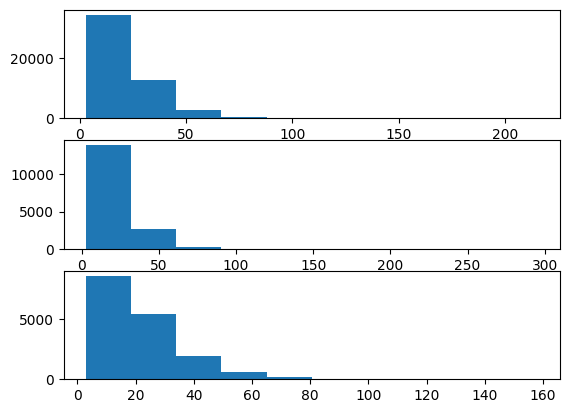

In [ ]:
fig, ax = plt.subplots(3, 1)

ax[0].hist(token_len_train)
ax[1].hist(token_len_valid)
ax[2].hist(token_len_test)

plt.show()

### Tokenization

In [16]:
tok = tokenizer.tokenize
max_len = 64
batch_size = 16

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False)
validset = BERTDataset(valid, 0, 1, tok, vocab, max_len, True, False)
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False)

In [17]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Model Training

### KoBERT Model

In [18]:
# get KoBERT model
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [19]:
# set params
num_classes = len(labels)
num_epochs = 20
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [20]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [21]:
model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=0.4).to(device)

In [22]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [23]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##### Training

In [ ]:
torch.cuda.empty_cache()

In [25]:
best_val_acc, best_val_loss = 0.0, 100.0
best_model = None

train_loss_epoch, val_loss_epoch = [], []

for e in range(num_epochs):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    print("epoch {} train acc {} loss {}".format(e+1, tot_train_acc, mean_train_loss))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        val_loss += loss.item()
        val_acc += calc_accuracy(out, label)
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    val_loss_epoch.append(mean_val_loss)
    print("epoch {} valid acc {} loss{}".format(e+1, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      mean_val_loss = mean_val_loss
      best_model = deepcopy(model.state_dict())

  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 1 train acc 0.5409619868731648 loss 1.3053546279782053


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 1 valid acc 0.622579666561148 loss1.061213911202332


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 2 train acc 0.6301582560884335 loss 1.0537016581062126


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 2 valid acc 0.6356969505117653 loss1.050927504175409


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 3 train acc 0.6779031608037308 loss 0.9281697235317302


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 3 valid acc 0.6363168724279835 loss1.0569590223707253


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 4 train acc 0.7344658587138005 loss 0.7751225430006426


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 4 valid acc 0.6322082410045373 loss1.1299226363981099


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 5 train acc 0.783536760895849 loss 0.6448141432581369


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 5 valid acc 0.6234831697794662 loss1.2776630233976802


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 6 train acc 0.8288779578559503 loss 0.5325908116687224


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 6 valid acc 0.6179038725335022 loss1.430419331743733


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 7 train acc 0.8642948644136105 loss 0.4402690469060256


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 7 valid acc 0.6123839295135592 loss1.5967882120909287


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 8 train acc 0.8950698802464161 loss 0.3679308219545328


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 8 valid acc 0.5827200063311174 loss1.8296188650421041


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 9 train acc 0.9155031953480339 loss 0.3129883109974693


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 9 valid acc 0.5926057824205972 loss2.2173888782200253


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 10 train acc 0.9349865421152628 loss 0.26614612014190087


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 10 valid acc 0.583696053603461 loss2.2809400403516586


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 11 train acc 0.9496912602913237 loss 0.21600965502445701


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 11 valid acc 0.6159319932468081 loss2.2740356329782507


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 12 train acc 0.960873179227359 loss 0.1754765750504405


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 12 valid acc 0.627400548696845 loss2.489949404825399


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 13 train acc 0.9706103546548448 loss 0.13982114071541651


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 13 valid acc 0.6271037775667406 loss2.550692954520781


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 14 train acc 0.9776667482296045 loss 0.10933686346203464


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 14 valid acc 0.6289107840033766 loss2.704436504496978


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 15 train acc 0.9836130462317922 loss 0.08141713842893068


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 15 valid acc 0.6306188667299778 loss2.777783467433462


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 16 train acc 0.9887784990500317 loss 0.05554984273667524


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 16 valid acc 0.6339295135591433 loss2.9040812078577263


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 17 train acc 0.9912721659278024 loss 0.04387819861029099


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 17 valid acc 0.6336920966550597 loss3.0045296656485676


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 18 train acc 0.9936470867637746 loss 0.031529240091166894


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 18 valid acc 0.6331447187928669 loss3.0277385072108687


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 19 train acc 0.9947355921469284 loss 0.02560149914820207


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 19 valid acc 0.6321356969505117 loss3.05222784598771


  0%|          | 0/3158 [00:00<?, ?it/s]

epoch 20 train acc 0.9952501583280557 loss 0.023297648205711022


  0%|          | 0/1053 [00:00<?, ?it/s]

epoch 20 valid acc 0.6317795715943865 loss3.058735113606876


In [29]:
torch.save(best_model, 'KoBERT_best.pt')

In [28]:
import pickle
with open('KoBERT-7.pkl', 'wb') as f:
  pickle.dump(best_model, f)

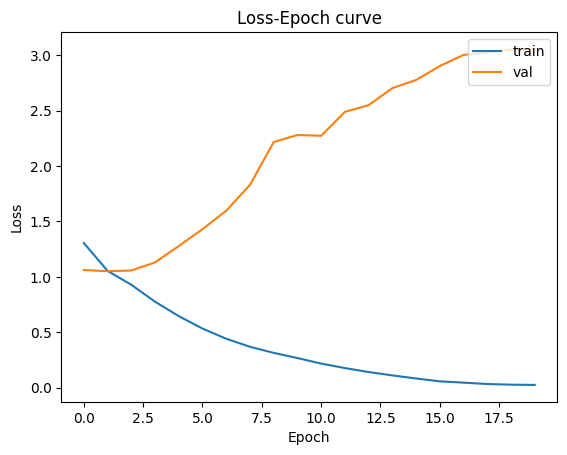

In [30]:
plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('Loss-Epoch curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

##### Evaluation

In [31]:
pre_trained_model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=0.4).to(device)
pre_trained_model.load_state_dict(torch.load('KoBERT_best.pt'))

<All keys matched successfully>

In [33]:
model.eval()
val_acc = 0.0
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length = valid_length
  label = label.long().to(device)
  out = model(token_ids, valid_length, segment_ids)
  val_acc += calc_accuracy(out, label)
tot_acc = val_acc / (batch_id+1)
print(f"Test acc {tot_acc}")

  0%|          | 0/1053 [00:00<?, ?it/s]

Test acc 0.6341933101192361
